<a href="https://colab.research.google.com/github/raj-vijay/da/blob/master/07_The_N_Queens_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BACKGROUND**

Is it possible to place 𝑁 queens on a chess board of 𝑁 × 𝑁 fields so that no two queens are threatening each other, i.e. are not in the same line horizontally, vertically, or diagonally?

**Task 1**

Write a Python program that creates a CP-SAT model of the n-queens problem. Choose a suitable model and add all variables and constraints to the model.

In [ ]:
!pip install ortools

     |████████████████████████████████| 13.7MB 278kB/s 
     |████████████████████████████████| 1.3MB 47.7MB/s 
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [ ]:
from ortools.sat.python import cp_model
from itertools import combinations
import matplotlib.pyplot as plt

**Task 2**

Implement a CpSolverSolutionCallback that prints each solution as follows:


```
---------------------------------
| Q |   |   |   |   |   |   |   |
---------------------------------
|   |   |   |   |   |   | Q |   |
---------------------------------
|   |   |   |   | Q |   |   |   |
---------------------------------
|   |   |   |   |   |   |   | Q |
---------------------------------
|   | Q |   |   |   |   |   |   |
---------------------------------
|   |   |   | Q |   |   |   |   |
---------------------------------
|   |   |   |   |   | Q |   |   |
---------------------------------
|   |   | Q |   |   |   |   |   |
---------------------------------
```

**Task 3**

Solve the model and evaluate the performance for finding 1 solution (use self.StopSearch() in the OnSolutionCallback function) and for finding all solutions using the solver.ResponseStats() function.

In [ ]:
maxTimePerSolve = 10

In [ ]:
class SolutionPrinter_A(cp_model.CpSolverSolutionCallback):
    def __init__(self, N,field,verbose,all_solutions):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.field_ = field
        self.verbose_ = verbose
        self.N_ = N
        self.all_solutions_ = all_solutions
        self.solutions_ = 0

    def OnSolutionCallback(self):    
        self.solutions_ = self.solutions_ + 1
        if self.verbose_:
            print("solution",self.solutions_)
            print("-",end="")
            print("----"*self.N_)
            for i in range(self.N_):
                line="|"
                for j in range(self.N_):
                    if (self.Value(self.field_[i][j])):
                        line = line + " Q |"
                    else:
                        line = line + "   |"
                print(line)
                print("-",end="")
                print("----"*self.N_)
        if not self.all_solutions_:
            self.StopSearch()

In [ ]:
def queens_A(N, all_solutions, verbose):
    model = cp_model.CpModel()
    
    field = []
    for i in range(N):
        row = []
        for j in range(N):
            row.append(model.NewBoolVar(str(i)+"_"+str(j)))
        field.append(row)
        
    for i in range(N):
        for j in range(N):
            horizontal = []
            vertical = []
            for k in range(N):
                if j!=k:
                    horizontal.append(field[i][k].Not())
                if i!=k:
                    vertical.append(field[k][j].Not())
            diagonal = []
            for k in range(1,N):
                if ((i-k)>=0) and ((j-k)>=0):
                    diagonal.append(field[i-k][j-k].Not())
                if ((i+k)<N) and ((j+k)<N):
                    diagonal.append(field[i+k][j+k].Not())
                if ((i+k)<N) and ((j-k)>=0):
                    diagonal.append(field[i+k][j-k].Not())
                if ((i-k)>=0) and ((j+k)<N):
                    diagonal.append(field[i-k][j+k].Not())
            model.AddBoolAnd(horizontal).OnlyEnforceIf(field[i][j])
            model.AddBoolAnd(vertical).OnlyEnforceIf(field[i][j])
            model.AddBoolAnd(diagonal).OnlyEnforceIf(field[i][j])

    booleanSAT = False
    if booleanSAT:
        coords = []
        for i in range(N):
            for j in range(N):
                coords.append((i,j))    
        queen_positionings = []
        for queen_at in combinations(coords, N):        
            queen_positioning = model.NewBoolVar(str(queen_at))
            queen_positionings.append(queen_positioning)
            for i in range(N):
                for j in range(N):                
                    if (i,j) in queen_at:
                        model.AddBoolOr([field[i][j]]).OnlyEnforceIf(queen_positioning)
                    else:
                        model.AddBoolOr([field[i][j].Not()]).OnlyEnforceIf(queen_positioning)
        model.AddBoolOr(queen_positionings)
    else:
        all_fields = []
        for i in range(N):
            for j in range(N):
                all_fields.append(field[i][j])
        model.Add(sum(all_fields)==N)    
    
    model.AddDecisionStrategy(row, 
                              cp_model.CHOOSE_FIRST, 
                              cp_model.SELECT_MIN_VALUE)

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = maxTimePerSolve

    if verbose:
        print("Model A, N =",N)

    sp = SolutionPrinter_A(N, field, verbose, all_solutions)    
    status = solver.SearchForAllSolutions(model, sp)

    if verbose:     
        print("# of solutions: ", sp.solutions_)
        print()
        
    return solver.WallTime(), status, solver.ResponseStats()


In [ ]:
class SolutionPrinter_B(cp_model.CpSolverSolutionCallback):
    def __init__(self, N,row,col,verbose,all_solutions):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.row_ = row
        self.col_ = col
        self.verbose_ = verbose
        self.N_ = N
        self.all_solutions_ = all_solutions
        self.solutions_ = 0

    def OnSolutionCallback(self):    
        self.solutions_ = self.solutions_ + 1
        if self.verbose_:
            print("solution",self.solutions_)
            print("-",end="")
            print("----"*self.N_)
            for i in range(self.N_):
                line="|"
                for j in range(self.N_):
                    occupied = False 
                    for k in range(self.N_):
                        if (self.Value(self.row_[k])==i) and (self.Value(self.col_[k])==j):
                            occupied = True
                            break                        
                    if occupied:
                        line = line + " Q |"
                    else:
                        line = line + "   |"                    
                print(line)
                print("-",end="")
                print("----"*self.N_)
        if not self.all_solutions_:
            self.StopSearch()          

In [ ]:
def queens_B(N, all_solutions, verbose):
    model = cp_model.CpModel()
    
    row = []
    col = []
    for i in range(N):
        row.append(model.NewIntVar(0,N-1,"row"+str(i)))
        col.append(model.NewIntVar(0,N-1,"col"+str(i)))

    useAllDifferent = False
    imposeOrdering = True

    if useAllDifferent:
        model.AddAllDifferent(row)
        model.AddAllDifferent(col)
    else:            
        for i in range(N):
            for j in range(i+1,N):
                model.Add(row[i]!=row[j]) 
                model.Add(col[i]!=col[j])            

    for i in range(N):
        for j in range(i+1,N):
            model.Add(row[i]-row[j] != col[i]-col[j])
            model.Add(row[i]-row[j] != col[j]-col[i])            
            if imposeOrdering:
                model.Add(row[i]<row[j])   
        
#    model.AddDecisionStrategy(row, cp_model.CHOOSE_FIRST, cp_model.SELECT_MIN_VALUE)

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = maxTimePerSolve

    if verbose:
        print("Model B, N =",N)

    sp = SolutionPrinter_B(N,row,col, verbose, all_solutions)    
    status = solver.SearchForAllSolutions(model, sp)

    if verbose:     
        print("# of solutions: ", sp.solutions_)
        print()
        
    return solver.WallTime(), status, solver.ResponseStats()


In [ ]:
class SolutionPrinter_C(cp_model.CpSolverSolutionCallback):
    def __init__(self, N, row, verbose,all_solutions):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.row_ = row
        self.verbose_ = verbose
        self.N_ = N
        self.all_solutions_ = all_solutions
        self.solutions_ = 0

    def OnSolutionCallback(self):    
        self.solutions_ = self.solutions_ + 1
        if self.verbose_:
            print("solution",self.solutions_)
            print("-",end="")
            print("----"*self.N_)
            for i in range(self.N_):
                line="|"
                for j in range(self.N_):
                    if (self.Value(self.row_[j])==i):
                        line = line + " Q |"
                    else:
                        line = line + "   |"                    
                print(line)
                print("-",end="")
                print("----"*self.N_)
        if not self.all_solutions_:
            self.StopSearch()       

In [ ]:
def queens_C(N, all_solutions, verbose):
    model = cp_model.CpModel()
    
    row = []
    for i in range(N):
        row.append(model.NewIntVar(0,N-1,"row"+str(i)))
    
    useAllDifferent = True

    if useAllDifferent:
        model.AddAllDifferent(row)
    else:
        for i in range(N):
            for j in range(i+1,N):
                model.Add(row[i]!=row[j])

    for i in range(N):
        for j in range(i+1,N):
            model.Add(row[i]-row[j] != i-j)
            model.Add(row[i]-row[j] != j-i)

#    model.AddDecisionStrategy(row, cp_model.CHOOSE_MIN_DOMAIN_SIZE, cp_model.SELECT_LOWER_HALF)

    solver = cp_model.CpSolver()
    solver.parameters.max_time_in_seconds = maxTimePerSolve
    
    print("Model C, N =",N)
    
    sp = SolutionPrinter_C(N,row, verbose, all_solutions)    
    status = solver.SearchForAllSolutions(model, sp)
        
    if verbose:     
        print("# of solutions: ", sp.solutions_)
        print()
        
    return solver.WallTime(), status, solver.ResponseStats()
        

In [ ]:
def test():
    N = 4
    all_solutions = True
    verbose = True
    
    modelA = False
    modelB = False
    modelC = True

    if modelA:
        time, status, rsA = queens_A(N, all_solutions, verbose)                        
    if modelB:
        time, status, rsB = queens_B(N, all_solutions, verbose)                
    if modelC:
        time, status, rsC = queens_C(N, all_solutions, verbose)                

    if modelA:    
        print("Model A")
        print("N = ",N)
        print(rsA)
    
    if modelB:    
        print("Model B")    
        print("N = ",N)
        print(rsB)
        
    if modelC:    
        print("Model C")    
        print("N = ",N)
        print(rsC)

In [ ]:
def evaluation():
    modelAPerformance = {False:{},True:{}}
    modelBPerformance = {False:{},True:{}}
    modelCPerformance = {False:{},True:{}}
    verbose = False
    for all_solutions in [False]:        
        modelA = False
        modelB = True
        modelC = True
        for N in range(4,100):
            print("Find all =", all_solutions, ", N =",N)
            if modelA:    
                print("Calculating model A")
                time, status, rsA = queens_A(N, all_solutions, verbose)                
                if ((all_solutions==True) and (status!=cp_model.OPTIMAL)) or ((all_solutions==False) and (status!=cp_model.FEASIBLE)):
                    modelA = False
                else:
                    modelAPerformance[all_solutions][N] = time
                    print("Time =", time)

            if modelB:    
                print("Calculating model B")
                time, status, rsB = queens_B(N, all_solutions, verbose)
                if ((all_solutions==True) and (status!=cp_model.OPTIMAL)) or ((all_solutions==False) and (status!=cp_model.FEASIBLE)):
                    modelB = False
                else:
                    modelBPerformance[all_solutions][N] = time
                    print("Time =", time)
        
            if modelC:    
                print("Calculating model C")
                time, status, rsC = queens_C(N, all_solutions, verbose)
                if ((all_solutions==True) and (status!=cp_model.OPTIMAL)) or ((all_solutions==False) and (status!=cp_model.FEASIBLE)):
                    modelC = False
                else:
                    modelCPerformance[all_solutions][N] = time
                    print("Time =", time)

    return modelAPerformance, modelBPerformance, modelCPerformance


In [ ]:

def plot_results(modelAPerformance, modelBPerformance, modelCPerformance):
    plt.close('all')
    plt.figure()

    X = []
    Y = []
    for x in modelAPerformance[False]:
        X.append(x)
        Y.append(modelAPerformance[False][x])    
    plt.plot(X,Y,'-r')

    X = []
    Y = []
    for x in modelAPerformance[True]:
        X.append(x)
        Y.append(modelAPerformance[True][x])    
    plt.plot(X,Y,'-g')

    X = []
    Y = []
    for x in modelBPerformance[False]:
        X.append(x)
        Y.append(modelBPerformance[False][x])    
    plt.plot(X,Y,'-b')

    X = []
    Y = []
    for x in modelBPerformance[True]:
        X.append(x)
        Y.append(modelBPerformance[True][x])    
    plt.plot(X,Y,'-c')

    X = []
    Y = []
    for x in modelCPerformance[False]:
        X.append(x)
        Y.append(modelCPerformance[False][x])    
    plt.plot(X,Y,'-m')

    X = []
    Y = []
    for x in modelCPerformance[True]:
        X.append(x)
        Y.append(modelCPerformance[True][x])    
    plt.plot(X,Y,'-y')
    

Model C, N = 4
solution 1
-----------------
|   |   | Q |   |
-----------------
| Q |   |   |   |
-----------------
|   |   |   | Q |
-----------------
|   | Q |   |   |
-----------------
solution 2
-----------------
|   | Q |   |   |
-----------------
|   |   |   | Q |
-----------------
| Q |   |   |   |
-----------------
|   |   | Q |   |
-----------------
# of solutions:  2

Model C
N =  4
CpSolverResponse:
status: OPTIMAL
objective: 0
best_bound: 0
booleans: 16
conflicts: 0
branches: 17
propagations: 135
integer_propagations: 216
walltime: 0.0107627
usertime: 0.0107627
deterministic_time: 0.000151254
primal_integral: 0

Find all = False , N = 4
Calculating model B
Time = 0.002408852
Calculating model C
Model C, N = 4
Time = 0.0013690290000000001
Find all = False , N = 5
Calculating model B
Time = 0.0024795340000000003
Calculating model C
Model C, N = 5
Time = 0.0028360670000000003
Find all = False , N = 6
Calculating model B
Time = 0.0036717570000000003
Calculating model C
Model C,

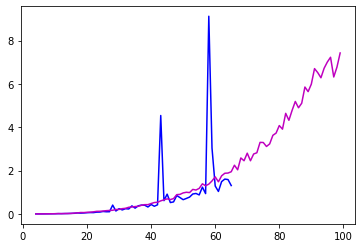

In [ ]:
test()
modelAPerformance, modelBPerformance, modelCPerformance = evaluation()
plot_results(modelAPerformance, modelBPerformance, modelCPerformance)